# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [201]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import re # regular expression # for text cleaning
import string
# draw plot here
%matplotlib inline 

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02


In [2]:
# help(BinaryClassificationPerformance)


In [3]:
# simple testing space - process_raw_data not easy to print
# eng_stop = ["i", "ive", "im", "id", "me", "my", "myself", "we", "weve", "were", "our", "ours", "ourselves", "you", "youve", "youre","youd", "your", "yours", "yourself", "yourselves", "he", "hes", "hed", "him", "his", "himself", "she", "shes", "her", "hers", "herself", "it", "its", "itself", "they", "theyre", "theyve","them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
# movie_stop = ["movie", "film", "video"]
# all_stop = eng_stop + movie_stop
# print (all_stop)    

['i', 'ive', 'im', 'id', 'me', 'my', 'myself', 'we', 'weve', 'were', 'our', 'ours', 'ourselves', 'you', 'youve', 'youre', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'hes', 'hed', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'theyre', 'theyve', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'o

# Function for feature building and extraction on natural language data

In [247]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t') #fn filename  
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(10))
    
    if (not test): 
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean()) # good 1 - bad 0

    # word and punctuation count, before cleaning     
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.") 
    movie_data['interrobang_count']  = len(re.findall('(\?\!)', str(movie_data['review']))) + len(re.findall('(\!\?)', str(movie_data['review']))) 
    movie_data['multi_q_count'] = len(re.findall('(\?){2,}', str(movie_data['review'])))
    ## Text Cleaning ##   
    def initial_cleaning(t):
            t = t.lower() # all Lowercase
            t = re.sub('\<.*?\>', '', t) # remove text inside < > - Any HTML markup
            t = re.sub('[%s]' % re.escape(string.punctuation), '', t)  # remove all punctuation
            return t      
    movie_data.review = movie_data.review.apply(lambda x: initial_cleaning(str(x)))
    # stop words manual set up - count - remove
    eng_stop = ["i", "ive", "im", "id", "me", "my", "myself", "we", "weve", "were", "our", "ours", "ourselves", "you", "youve", "youre","youd", "your", "yours", "yourself", "yourselves", "he", "hes", "hed", "him", "his", "himself", "she", "shes", "her", "hers", "herself", "it", "its", "itself", "they", "theyre", "theyve","them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
    movie_stop = ["movie", "film", "video"]
    all_stop = eng_stop + movie_stop
    #
    movie_data['stop_count'] = movie_data['review'].apply(lambda x: len([x for x in x.split() if x in all_stop])) 
    movie_data['review'] = movie_data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in all_stop)) 
    # newly calculated word count
    movie_data['remainders_count'] = movie_data['review'].str.split(' ').str.len()
    # Check some review data here 
    print("Sample of clean movie_data review: ")
    print (movie_data.review.sample(n=3, random_state=10))

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 27, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
        
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    # already normalized
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)   
    
    # create additional quantitative features
    # features to add to feature set
    # got rid of "word_count", "punc_count", "stop_count",  and added others
    #X_quant_features = movie_data[["remainders_count"]] 
    X_quant_features = movie_data[["remainders_count", "interrobang_count", "multi_q_count"]] 
    #X_quant_features = movie_data[["word_count"]] 
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(100))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features) # csr - Compressed Sparse Row matrix
    X_combined = hstack([X_tfidf, X_quant_features_csr]) # hstack - Stack sparse matrices horizontally (column wise)
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
        
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [248]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGED FILE PATH and my_random_seed number : 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../final_data/moviereviews_train.tsv', my_random_seed=99)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10  

# Fit (and tune) Various Models

### MODEL: SVM, linear

In [205]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9988, 'TN': 10012, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [249]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', max_iter=10000, alpha=0.5)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9976, 'TN': 10006, 'FP': 6, 'FN': 12, 'Accuracy': 0.9991, 'Precision': 0.9993989180524945, 'Recall': 0.9987985582699239, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [212]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9901, 'TN': 9949, 'FP': 63, 'FN': 87, 'Accuracy': 0.9925, 'Precision': 0.9936772380570053, 'Recall': 0.9912895474569483, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [213]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9988, 'TN': 10012, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [214]:
# from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.5, normalize = True, solver = 'sag', max_iter = 10000) # Larger alpha values specify stronger regularization.
# Other attributes: fit_intercept = False -> Ignores normalization  - Conflict
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9975, 'TN': 10007, 'FP': 5, 'FN': 13, 'Accuracy': 0.9991, 'Precision': 0.999498997995992, 'Recall': 0.9986984381257509, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [215]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/inhyelee/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9988, 'Neg': 10012, 'TP': 9869, 'TN': 394, 'FP': 9618, 'FN': 119, 'Accuracy': 0.51315, 'Precision': 0.5064401908964951, 'Recall': 0.9880857028434121, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

-SVM-
True Positive rate: 
1.0
False Positive rate: 
0.0
-Logistic-
True Positive rate: 
0.9989987985582699
False Positive rate: 
0.0005992808629644426
-Naive Bayes-
True Positive rate: 
0.9912895474569483
False Positive rate: 
0.006292449061126648
-Perceptron-
True Positive rate: 
1.0
False Positive rate: 
0.0
-Ridge R-
True Positive rate: 
0.9986984381257509
False Positive rate: 
0.0004994007191370355
-Random Forest-
True Positive rate: 
0.9880857028434121
False Positive rate: 
0.9606472233320016


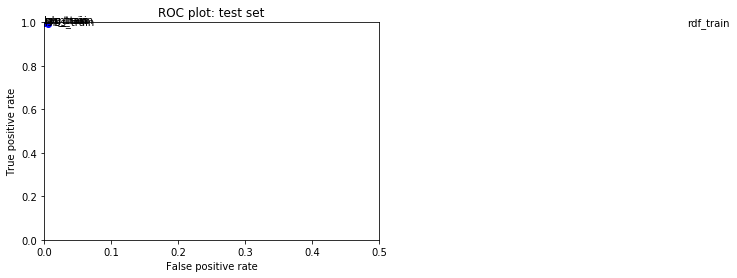

In [216]:
# Removed are ols_performance_train
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
fits_name = ["-SVM-", "-Logistic-", "-Naive Bayes-", "-Perceptron-", "-Ridge R-", "-Random Forest-"]
for i, fit in enumerate(fits): 
    TP_POS_rate = fit.performance_measures['TP'] / fit.performance_measures['Pos']
    FP_NEG_rate = fit.performance_measures['FP'] / fit.performance_measures['Neg']
    # print in numbers 
    print(fits_name[i])
    print("True Positive rate: ")
    print(TP_POS_rate)
    print("False Positive rate: ")
    print(FP_NEG_rate)
    # plt
    plt.plot(FP_NEG_rate, TP_POS_rate, 'bo')
    plt.text(FP_NEG_rate, TP_POS_rate, fit.desc)
# draw
plt.axis([0, 0.5, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()



### looking at reviews based on their classification

Let's say we decide that RDG is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [15]:
rdg_predictions = rdg.predict(X_train)

### let's look at some false positives:

In [16]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: SVM, linear

In [251]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 2095, 'TN': 2045, 'FP': 443, 'FN': 417, 'Accuracy': 0.828, 'Precision': 0.8254531126871553, 'Recall': 0.8339968152866242, 'desc': 'svm_test'}


### MODEL: logistic regression

In [250]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 2236, 'TN': 2187, 'FP': 301, 'FN': 276, 'Accuracy': 0.8846, 'Precision': 0.8813559322033898, 'Recall': 0.8901273885350318, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [252]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 1909, 'TN': 1780, 'FP': 708, 'FN': 603, 'Accuracy': 0.7378, 'Precision': 0.7294612151318304, 'Recall': 0.759952229299363, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [253]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 2093, 'TN': 2053, 'FP': 435, 'FN': 419, 'Accuracy': 0.8292, 'Precision': 0.8279272151898734, 'Recall': 0.8332006369426752, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [255]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 2159, 'TN': 2253, 'FP': 235, 'FN': 353, 'Accuracy': 0.8824, 'Precision': 0.9018379281537177, 'Recall': 0.8594745222929936, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [256]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 2472, 'TN': 108, 'FP': 2380, 'FN': 40, 'Accuracy': 0.516, 'Precision': 0.5094806265457543, 'Recall': 0.9840764331210191, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

-SVM-
True Positive rate: 
0.8339968152866242
False Positive rate: 
0.17805466237942122
-Logistic-
True Positive rate: 
0.8901273885350318
False Positive rate: 
0.12098070739549839
-Naive Bayes-
True Positive rate: 
0.759952229299363
False Positive rate: 
0.2845659163987138
-Perceptron-
True Positive rate: 
0.8332006369426752
False Positive rate: 
0.17483922829581994
-Ridge R-
True Positive rate: 
0.8594745222929936
False Positive rate: 
0.09445337620578778
-Random Forest-
True Positive rate: 
0.9840764331210191
False Positive rate: 
0.9565916398713826


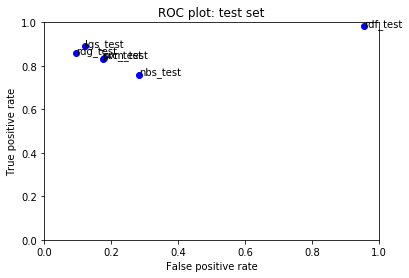

In [257]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
fits_name = ["-SVM-", "-Logistic-", "-Naive Bayes-", "-Perceptron-", "-Ridge R-", "-Random Forest-"]
for i, fit in enumerate(fits): 
    TP_POS_rate = fit.performance_measures['TP'] / fit.performance_measures['Pos']
    FP_NEG_rate = fit.performance_measures['FP'] / fit.performance_measures['Neg']
    # print in numbers 
    print(fits_name[i])
    print("True Positive rate: ")
    print(TP_POS_rate)
    print("False Positive rate: ")
    print(FP_NEG_rate)
    # plt
    plt.plot(FP_NEG_rate, TP_POS_rate, 'bo')
    plt.text(FP_NEG_rate, TP_POS_rate, fit.desc)
# draw
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [258]:
# read in test data for submission
# CHANGED - FILE PATH and my_random_seed number:  
raw_data, X_test_submission = process_raw_data(fn='../final_data/moviereviews_test.tsv', my_random_seed=99, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
5    2913_8  ...as valuable as King Tut's tomb! (OK, maybe ...
6    4396_1  This has to be one of the biggest misfires eve...
7     395_2  This is one of those movies I watched, and won...
8   10616_1  The worst movie i've seen in years (and i've s...
9    9074_9  Five medical students (Kevin Bacon, David Labr...
Sample of clean movie_data review: 
18634    one beautifully morbid films e

---

Choose a <span style="color:red">*single*</span> model for your submission.
I Switched from Ridge Regression to Logistic Regression 

In [259]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
# logistic regression selected
my_submission["prediction"] = lgs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean()) 

0.47964


In [260]:
raw_data.head(10)

,id,review,word_count,punc_count,interrobang_count,multi_q_count,stop_count,remainders_count
0,12311_10,naturally whos main themes mortality nostalgia...,131,5,0,0,61,70
1,8348_2,disaster within disaster full great action sce...,169,15,0,0,86,80
2,5828_4,kids saw tonight child loved one point kids ex...,176,18,0,0,91,81
3,7186_2,afraid dark left impression several different ...,112,5,0,0,55,52
4,12128_7,accurate depiction small time mob life filmed ...,133,8,0,0,54,75
5,2913_8,valuable king tuts tomb ok maybe valuable wort...,331,20,0,0,169,159
6,4396_1,one biggest misfires everthe script nice could...,121,18,0,0,58,56
7,395_2,one movies watched wondered watch find interes...,230,22,0,0,110,114
8,10616_1,worst seen years seen lot movies acting terrib...,59,3,0,0,31,27
9,9074_9,five medical students kevin bacon david labrac...,224,14,0,0,71,143


In [261]:
my_submission.head(10)

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,1
5,2913_8,1
6,4396_1,0
7,395_2,0
8,10616_1,0
9,9074_9,1


In [262]:
my_submission.shape

(25000, 2)

In [263]:
# export submission file as csv
# CHANGE FILE PATH: 
my_submission.to_csv('../final_data/moviereviews_submission_final.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation